In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
ratings = pd.read_csv('/content/drive/MyDrive/AI_mini_projects/9_Book_recommendation_system/BX-Book-Ratings.csv', error_bad_lines=False, delimiter=';', encoding = 'ISO-8859-1')
books = pd.read_csv('/content/drive/MyDrive/AI_mini_projects/9_Book_recommendation_system/BX-Books.csv', error_bad_lines=False, delimiter=';', encoding = 'ISO-8859-1')
users = pd.read_csv('/content/drive/MyDrive/AI_mini_projects/9_Book_recommendation_system/BX-Users.csv', error_bad_lines=False, delimiter=';', encoding = 'ISO-8859-1')

b'Skipping line 6452: expected 8 fields, saw 9\nSkipping line 43667: expected 8 fields, saw 10\nSkipping line 51751: expected 8 fields, saw 9\n'
b'Skipping line 92038: expected 8 fields, saw 9\nSkipping line 104319: expected 8 fields, saw 9\nSkipping line 121768: expected 8 fields, saw 9\n'
b'Skipping line 144058: expected 8 fields, saw 9\nSkipping line 150789: expected 8 fields, saw 9\nSkipping line 157128: expected 8 fields, saw 9\nSkipping line 180189: expected 8 fields, saw 9\nSkipping line 185738: expected 8 fields, saw 9\n'
b'Skipping line 209388: expected 8 fields, saw 9\nSkipping line 220626: expected 8 fields, saw 9\nSkipping line 227933: expected 8 fields, saw 11\nSkipping line 228957: expected 8 fields, saw 10\nSkipping line 245933: expected 8 fields, saw 9\nSkipping line 251296: expected 8 fields, saw 9\nSkipping line 259941: expected 8 fields, saw 9\nSkipping line 261529: expected 8 fields, saw 9\n'
/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:27

#1. Data exploration

In [ ]:
print(ratings.shape)
ratings.head(5)

(1149780, 3)


,User-ID,ISBN,Book-Rating
0,276725,034545104X,0
1,276726,0155061224,5
2,276727,0446520802,0
3,276729,052165615X,3
4,276729,0521795028,6


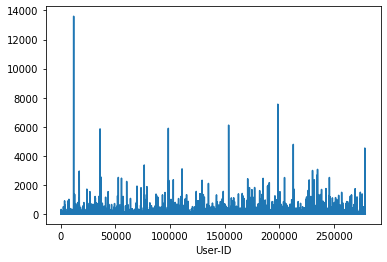

In [ ]:
ratings.groupby("User-ID")["Book-Rating"].count().plot()

In [ ]:
print(books.shape)
books.head(5)

(271360, 8)


,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...


In [ ]:
print(users.shape)
users.head(5)

(278858, 3)


,User-ID,Location,Age
0,1,"nyc, new york, usa",NaN
1,2,"stockton, california, usa",18.0
2,3,"moscow, yukon territory, russia",NaN
3,4,"porto, v.n.gaia, portugal",17.0
4,5,"farnborough, hants, united kingdom",NaN


In [ ]:
data = pd.merge(ratings, users, on='User-ID', how='inner')
data = pd.merge(data, books, on='ISBN', how='inner')
data.drop(['Image-URL-S', 'Image-URL-M', 'Image-URL-L'],axis=1,inplace=True)

In [ ]:
print(data.shape)
data.head(5)

(1031136, 9)


,User-ID,ISBN,Book-Rating,Location,Age,Book-Title,Book-Author,Year-Of-Publication,Publisher
0,276725,034545104X,0,"tyler, texas, usa",NaN,Flesh Tones: A Novel,M. J. Rose,2002,Ballantine Books
1,2313,034545104X,5,"cincinnati, ohio, usa",23.0,Flesh Tones: A Novel,M. J. Rose,2002,Ballantine Books
2,6543,034545104X,0,"strafford, missouri, usa",34.0,Flesh Tones: A Novel,M. J. Rose,2002,Ballantine Books
3,8680,034545104X,5,"st. charles county, missouri, usa",2.0,Flesh Tones: A Novel,M. J. Rose,2002,Ballantine Books
4,10314,034545104X,9,"beaverton, oregon, usa",NaN,Flesh Tones: A Novel,M. J. Rose,2002,Ballantine Books


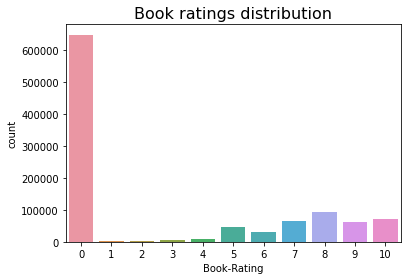

In [ ]:
plt.title('Book ratings distribution', fontsize=16)
sns.countplot(x='Book-Rating', data=data)

Text(0.5, 1.0, 'Rating count distribution per user')

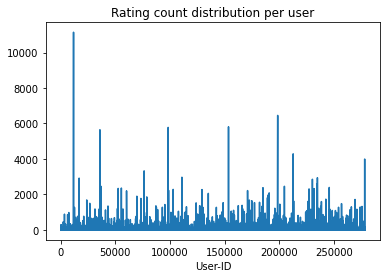

In [ ]:
data.groupby("User-ID")["Book-Rating"].count().plot()
plt.title('Rating count distribution per user')

Text(0.5, 1.0, 'Age distribution')

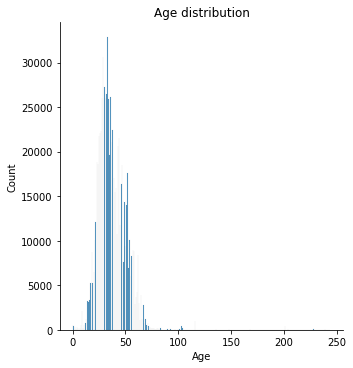

In [ ]:
sns.displot(data.Age)
plt.title('Age distribution')

In [ ]:
data['Book-Rating'] = data['Book-Rating'].replace({0:None})

median = data["Age"].median()
data['Age'] = np.where(data['Age']>90, median, data['Age'])

In [ ]:
data[['Book-Author', 'Publisher']] = data[['Book-Author', 'Publisher']].fillna('Unknown')

In [ ]:
data['Country'] = data['Location'].apply(lambda row: str(row).split(',')[-1])

In [ ]:
data

,User-ID,ISBN,Book-Rating,Location,Age,Book-Title,Book-Author,Year-Of-Publication,Publisher,Country
0,276725,034545104X,None,"tyler, texas, usa",NaN,Flesh Tones: A Novel,M. J. Rose,2002,Ballantine Books,usa
1,2313,034545104X,5,"cincinnati, ohio, usa",23.0,Flesh Tones: A Novel,M. J. Rose,2002,Ballantine Books,usa
2,6543,034545104X,None,"strafford, missouri, usa",34.0,Flesh Tones: A Novel,M. J. Rose,2002,Ballantine Books,usa
3,8680,034545104X,5,"st. charles county, missouri, usa",2.0,Flesh Tones: A Novel,M. J. Rose,2002,Ballantine Books,usa
4,10314,034545104X,9,"beaverton, oregon, usa",NaN,Flesh Tones: A Novel,M. J. Rose,2002,Ballantine Books,usa
...,...,...,...,...,...,...,...,...,...,...
1031131,276688,0517145553,None,"fort lee, new jersey, usa",NaN,Mostly Harmless,Douglas Adams,1995,Random House Value Pub,usa
1031132,276688,1575660792,7,"fort lee, new jersey, usa",NaN,Gray Matter,Shirley Kennett,1996,Kensington Publishing Corporation,usa
1031133,276690,0590907301,None,"wakeman, ohio, usa",43.0,Triplet Trouble and the Class Trip (Triplet Tr...,Debbie Dadey,1997,Apple,usa
1031134,276704,0679752714,None,"cedar park, texas, usa",NaN,A Desert of Pure Feeling (Vintage Contemporaries),Judith Freeman,1997,Vintage Books USA,usa


In [ ]:
data.dtypes

User-ID                  int64
ISBN                    object
Book-Rating             object
Location                object
Age                    float64
Book-Title              object
Book-Author             object
Year-Of-Publication     object
Publisher               object
Country                 object
dtype: object

In [ ]:
#pivot_table = data.pivot_table(index = ["User-ID"],columns = ["Book-Title"],values = ["Book-Rating"], aggfunc="first")

#2. Memory-based CF, users similariy

In [ ]:
users = data[['User-ID', 'Age', 'Country','ISBN','Book-Rating','Book-Title']]

In [ ]:
users_reduced = users.sample(n=8000).reset_index(drop=True)

In [ ]:
users_reduced.head(5)

,User-ID,Age,Country,ISBN,Book-Rating,Book-Title
0,25809,NaN,usa,0895772280,7,Gothic Treasure Trove
1,135265,32.0,usa,0373821670,5,Change Of Life
2,206534,NaN,usa,0836220498,None,Night Of Crash-Test Dummies
3,235105,46.0,usa,0060090421,8,Martin Quinn : A Novel of Suspense
4,268415,NaN,usa,0312276885,None,The Sigma Protocol


In [ ]:
matrix= users_reduced.pivot(index="User-ID",columns="ISBN",values="Book-Rating")

In [ ]:
matrix.fillna(0,inplace=True)

In [ ]:
cos_sim = cosine_similarity(matrix)
np.fill_diagonal(cos_sim,1)        
rec_cos=pd.DataFrame(cos_sim,index=matrix.index)
rec_cos.columns=matrix.index
rec_cos.head()

User-ID,254,311,388,446,475,487,507,569,620,709,714,819,882,901,929,1211,1435,1705,1719,1733,1745,1848,1900,1928,2033,2110,2197,2276,2288,2333,2363,2766,2793,2907,2977,3027,3052,3145,3192,3282,...,275638,275806,275906,275922,275933,275970,276018,276165,276181,276231,276346,276656,276680,276847,276925,276929,276964,277195,277243,277427,277523,277619,277639,277680,277711,277923,277965,278144,278188,278194,278221,278253,278418,278483,278488,278522,278565,278637,278652,278694
User-ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
254,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
311,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
388,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
446,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
475,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
def sim(userid,n):    
    print(np.array(rec_cos[userid].sort_values(ascending=False).head(n).index))

In [ ]:
print(np.array(rec_cos[1131].sort_values(ascending=False).head(5).index))

KeyError: ignored

In [ ]:
def recommending():              
    userid = int(input("User_id : "))
    n= int(input("Number of books : "))
    arr=np.array(rec_cos[userid].sort_values(ascending=False).head(5).index)

    recom_arr=[]

    for i in arr:
        recom_arr.append(data[data["User-ID"]==i][["Book-Title","Book-Rating"]].sort_values(by="Book-Rating",ascending=False))
    
    return(pd.Series(recom_arr[0].append([recom_arr[1],recom_arr[2],recom_arr[3],recom_arr[4]]).groupby("Book-Title")["Book-Rating"].mean().sort_values(ascending=False).index).head(n))

In [ ]:
recommending()

User_id : 254
Number of books : 6


DataError: ignored

In [ ]:
0747532745

# 3. Memory-based CF, item-based

In [ ]:
from sklearn.neighbors import NearestNeighbors

In [ ]:
data_ = data[data['Book-Rating'] >= 6][["User-ID", "ISBN", "Book-Rating"]]
#data_ = data[["User-ID", "ISBN", "Book-Rating"]]

In [ ]:
data_ = data_.groupby('ISBN').filter(lambda x: len(x) >= 5)

In [ ]:
data_ = data_.groupby('User-ID').filter(lambda x: len(x) >= 5)

In [ ]:
#To cope up with computing power I have and to reduce the dataset size, I am considering users who have rated atleast 100 books
#and books which have atleast 100 ratings
counts1 = data_['User-ID'].value_counts()
ratings_explicit = data_[data_['User-ID'].isin(counts1[counts1 >= 100].index)]
counts = data_['Book-Rating'].value_counts()
ratings_explicit = data_[data_['Book-Rating'].isin(counts[counts >= 100].index)]

In [ ]:
#Generating ratings matrix from explicit ratings table
ratings_matrix = ratings_explicit.pivot(index='User-ID', columns='ISBN', values='Book-Rating')
userID = ratings_matrix.index
ISBN = ratings_matrix.columns
print(ratings_matrix.shape)
ratings_matrix.head()
#Notice that most of the values are NaN (undefined) implying absence of ratings

(6310, 11451)


ISBN,0002005018,0002251760,0002259834,0002558122,0003300277,0006385427,000648302X,0006485200,0006485936,000649840X,0006546684,0006547834,0006550576,0006550789,0006550924,0006551971,0006742939,0007110928,0007122039,0007141076,0007154615,000716226X,0007170866,0020198817,0020198906,0020199600,0020264763,002026478X,0020264801,0020306652,0020360754,002040400X,0020418809,0020427859,0020442009,0020442106,0020442203,0020442300,0020442408,0020442505,...,8478886508,8478950257,8483101610,8484501965,8484502112,8484505294,8484602508,8495359537,8495501090,8495501112,8495501198,849550152X,8495501651,8495618605,8804342838,8806142100,8806143042,880781000X,8807810786,880781210X,8807813025,8807813823,8817106100,8817106259,8817131628,881787017X,8838910170,8838910987,8845205118,8845247414,8845915611,9074336329,9129622425,9500723549,950491036X,958704049X,9681500555,968150108X,9722105248,9871138148
User-ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
114,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
242,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
243,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
244,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
254,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
n_users = ratings_matrix.shape[0] #considering only those users who gave explicit ratings
n_books = ratings_matrix.shape[1]
print(n_users, n_books)

6310 11451


In [ ]:
#This function finds k similar items given the item_id and ratings matrix

def findksimilaritems(item_id, ratings, metric='cosine', k=10):
    similarities=[]
    indices=[]
    ratings=ratings.T
    loc = ratings.index.get_loc(item_id)
    model_knn = NearestNeighbors(metric = metric, algorithm = 'brute')
    model_knn.fit(ratings)
    
    distances, indices = model_knn.kneighbors(ratings.iloc[loc, :].values.reshape(1, -1), n_neighbors = k+1)
    similarities = 1-distances.flatten()

    return similarities,indices

In [ ]:
#since NaNs cannot be handled by training algorithms, replacing these by 0, which indicates absence of ratings
#setting data type
ratings_matrix.fillna(0, inplace = True)
ratings_matrix = ratings_matrix.astype(np.int32)

In [ ]:
#checking first few rows
ratings_matrix.head(5)

ISBN,0002005018,0002251760,0002259834,0002558122,0003300277,0006385427,000648302X,0006485200,0006485936,000649840X,0006546684,0006547834,0006550576,0006550789,0006550924,0006551971,0006742939,0007110928,0007122039,0007141076,0007154615,000716226X,0007170866,0020198817,0020198906,0020199600,0020264763,002026478X,0020264801,0020306652,0020360754,002040400X,0020418809,0020427859,0020442009,0020442106,0020442203,0020442300,0020442408,0020442505,...,8478886508,8478950257,8483101610,8484501965,8484502112,8484505294,8484602508,8495359537,8495501090,8495501112,8495501198,849550152X,8495501651,8495618605,8804342838,8806142100,8806143042,880781000X,8807810786,880781210X,8807813025,8807813823,8817106100,8817106259,8817131628,881787017X,8838910170,8838910987,8845205118,8845247414,8845915611,9074336329,9129622425,9500723549,950491036X,958704049X,9681500555,968150108X,9722105248,9871138148
User-ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
114,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
242,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
243,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
244,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
254,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
similarities,indices=findksimilaritems('0002558122',ratings_matrix)

In [ ]:
#This function predicts the rating for specified user-item combination based on item-based approach

def predict_itembased(user_id, item_id, ratings, metric="cosine", k=10):
    prediction= wtd_sum =0
    user_loc = ratings.index.get_loc(user_id)
    item_loc = ratings.columns.get_loc(item_id)
    similarities, indices=findksimilaritems(item_id, ratings)
    sum_wt = np.sum(similarities)-1
    product=1
    for i in range(0, len(indices.flatten())):
        if indices.flatten()[i] == item_loc:
            continue;
        else:
            product = ratings.iloc[user_loc,indices.flatten()[i]] * (similarities[i])
            wtd_sum = wtd_sum + product                              
    prediction = int(round(wtd_sum/sum_wt))
    
    if prediction <= 0:
        prediction = 1   
    elif prediction >10:
        prediction = 10

    print('\nPredicted rating for user {0} -> item {1}: {2}'.format(user_id,item_id,prediction))
    
    return prediction

In [ ]:
prediction = predict_itembased(11676,'0002558122',ratings_matrix)


Predicted rating for user 11676 -> item 0002558122: 8
